In [167]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, UnetPlusPlus, DeepLabV3Plus, MAnet, FPN
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.utils import train as smp_train
from segmentation_models_pytorch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.profilers import AdvancedProfiler

from torchmetrics.segmentation import MeanIoU
from torchmetrics import Accuracy, F1Score
from torchmetrics import Precision, Recall, Dice

import cv2
from sklearn.model_selection import train_test_split

import numpy as np
import random

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# LOAD AND DISPLAY TRAIN SET

In [256]:
class SonarDataset(Dataset):
    def __init__(self, data_paths, mask_paths, resize_size=512, num_patches_per_image=3):
        self.data_paths = data_paths
        self.mask_paths = mask_paths
        self.resize_size = resize_size
        self.num_patches_per_image = num_patches_per_image
        
        # Transformations applied on the patches, NO IMAGENET
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])

        # IMAGENET NORMALIZAZION
        #transform = transforms.Compose([
        #    transforms.ToTensor(),  # Applies only if your data is not already a tensor
        #    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #])

    def __len__(self):
        return len(self.data_paths) * self.num_patches_per_image

    def __getitem__(self, idx):
        file_idx = idx // self.num_patches_per_image
        data_path = self.data_paths[file_idx]
        mask_path = self.mask_paths[file_idx]

        image = np.load(data_path, mmap_mode='r')
        mask = np.load(mask_path, mmap_mode='r')
        patch_size = image.shape[0]

        max_x = image.shape[1] - patch_size
        if max_x <= 0:
            raise ValueError("Patch size is larger than the image width.")

        x = random.randint(0, max_x)
        image_patch = image[:, x:x + patch_size]
        mask_patch = mask[:, x:x + patch_size]

        if self.resize_size != patch_size:
            image_patch = cv2.resize(image_patch, (self.resize_size, self.resize_size))
            mask_patch = cv2.resize(mask_patch, (self.resize_size, self.resize_size), interpolation=cv2.INTER_NEAREST)

        # Apply transformations        
        #image_patch = image_patch.astype(np.float32)
        #image_patch = self.transforms(image_patch)  # HWC to CHW format conversion before applying ToTensor
        #mask_patch = mask_patch.astype(np.float32)
        #mask_patch = np.expand_dims(mask_patch, axis=0)  # Adding channel dimension for the mask

        image_patch = self.transforms(image_patch.astype(np.float32))
        mask_patch = torch.tensor(mask_patch, dtype=torch.float32).unsqueeze(0)

        return image_patch, mask_patch

class SonarTestDataset(Dataset):
    def __init__(self, data_paths, mask_paths=None):
        self.data_paths = data_paths
        self.mask_paths = mask_paths
        
        # Transformations applied on the patches, NO IMAGENET
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])

        # IMAGENET NORMALIZAZION
        #transform = transforms.Compose([
        #    transforms.ToTensor(),  # Applies only if your data is not already a tensor
        #    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #])

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        image_path = self.data_paths[idx]
        image = np.load(image_path)  
        image = self.transforms(image.astype(np.float32))

        mask = None
        if self.mask_paths is not None:
            mask_path = self.mask_paths[idx]
            mask = np.load(mask_path)  # Assuming masks are stored in .npy format
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask, os.path.basename(image_path)

In [5]:
import os

# Define paths to images and masks
image_dir = '/home/ubuntu/Sonar_data/Herring_training_data/images/'
mask_dir = '/home/ubuntu/Sonar_data/Herring_training_data/masks'

image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, msk) for msk in os.listdir(mask_dir)]
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Create datasets
train_dataset = SonarDataset(train_images, train_masks)
val_dataset = SonarDataset(val_images, val_masks)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
images, masks = next(iter(train_loader))

print(f'Images shape: {images.shape}')
print(f'Masks shape: {masks.shape}')

Images shape: torch.Size([4, 3, 512, 512])
Masks shape: torch.Size([4, 1, 512, 512])


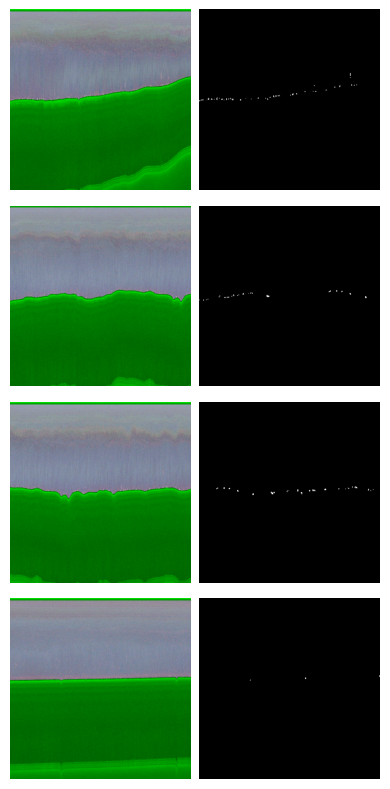

In [262]:
import matplotlib.pyplot as plt

def show_img_mask(loader, num_images_to_display = 4, test = False):
    if test: images, masks, _ = next(iter(loader))    
    else: images, masks = next(iter(loader))   
        
    # Convert tensors to numpy arrays for visualization
    images_np = images.numpy()  # In shape (N, C, H, W)
    masks_np = masks.numpy()  # In shape (N, H, W)
    
    images_np = images_np.transpose((0, 2, 3, 1))
    masks_np = masks_np.transpose((0, 2, 3, 1))
    
    fig, axes = plt.subplots(num_images_to_display, 2, figsize=(4, 2 * num_images_to_display))
    
    for i in range(num_images_to_display):
        # Display the image
        axes[i, 0].imshow(images_np[i])
        axes[i, 0].axis('off')
    
        # Display the mask
        axes[i, 1].imshow(masks_np[i], cmap='gray')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

show_img_mask(train_loader)

# TRAIN THE MODEL

In [268]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2, logits=True, reduction='mean'):
        """
        Parameters:
        alpha (tensor, optional): Weights for each class. Default is equal weight.
        gamma (int, optional): Focusing parameter. Default is 2.
        logits (bool, optional): If True, expects inputs as raw logits. If False, expects probabilities. Default is True.
        reduction (str, optional): Specifies the reduction to apply to the output: 'none', 'mean', 'sum'. Default is 'mean'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha if alpha is not None else torch.tensor([1.0, 1.0])
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            # Compute the binary cross-entropy loss with logits
            BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            # Compute the binary cross-entropy loss
            BCE_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        
        # Ensure targets are on the same device as inputs
        targets = targets.to(inputs.device).long()
        # Ensure alpha is on the same device as targets
        self.alpha = self.alpha.to(inputs.device)
        # Dynamic alpha based on target class
        alpha = self.alpha[targets]
        
        # Compute the modulating factor (1 - pt)^gamma
        pt = torch.exp(-BCE_loss)
        focal_loss = alpha * ((1 - pt) ** self.gamma) * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss


class SegModel(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

        self.iou = MeanIoU(num_classes=2)  
        self.precision = Precision(task="binary", num_classes=2, average='none')
        self.recall = Recall(task="binary", num_classes=2, average='none')
        self.f1 = F1Score(task="binary", num_classes=2, average='none')
        self.dice = Dice(num_classes=2)

        self.test_outputs = []
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        image, mask = batch
        out = self.forward(image)
        
        # Ensure mask is float for focal loss compatibility
        loss = self.criterion(out, mask.float())  
        
        # Convert logits to binary predictions
        preds = (out.sigmoid() > 0.5).long()
        
        tp, fp, fn, tn = smp.metrics.get_stats(preds, mask.long(), mode='binary')
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_loss", loss) 
        return {"loss": loss, "iou": iou}
        
    def training_step(self, batch, batch_idx):
        torch.cuda.empty_cache()  # Clear cache after each batch
        return self.shared_step(batch, "train")     

    def validation_step(self, batch, batch_idx):
        torch.cuda.empty_cache()  # Clear cache after each batch
        return self.shared_step(batch, "valid")

    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        preds = torch.sigmoid(logits) > 0.5
        preds = preds.int()  # Convert boolean to integers
        y = y.int()  # Ensure targets are also integers
        
        # Update metrics
        iou_score = self.iou(preds, y)
        dice_score = self.dice(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)
        f1 = self.f1(preds, y)
    
        # Log metrics
        self.log('iou_score', iou_score, on_step=False, on_epoch=True)
        self.log('dice_score', dice_score, on_step=False, on_epoch=True)
        self.log('precision', precision, on_step=False, on_epoch=True)
        self.log('recall', recall, on_step=False, on_epoch=True)
        self.log('f1', f1, on_step=False, on_epoch=True)

        outputs = {
            "iou": iou_score,
            "dice": dice_score,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

        self.test_outputs.append(outputs)
        
        return outputs

    def on_test_epoch_end(self):
        # Aggregate metrics
        iou_scores = torch.stack([x['iou'] for x in self.test_outputs])
        dice_scores = torch.stack([x['dice'] for x in self.test_outputs])
        precisions = torch.stack([x['precision'] for x in self.test_outputs])
        recalls = torch.stack([x['recall'] for x in self.test_outputs])
        f1_scores = torch.stack([x['f1'] for x in self.test_outputs])

        avg_iou = iou_scores.mean()
        avg_dice = dice_scores.mean()
        avg_precision = precisions.mean()
        avg_recall = recalls.mean()
        avg_f1 = f1_scores.mean()

        # Log aggregated metrics
        #self.log('av_iou_score', avg_iou)
        #self.log('av_dice_score', avg_dice)
        #self.log('av_precision', avg_precision)
        #self.log('av_recall', avg_recall)
        #self.log('av_f1', avg_f1)

        # Clear the outputs for the next epoch
        self.test_outputs = []

    def predict(self, dataloader, output_dir=None):
        self.eval()  # Set model to evaluation mode

        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                # Assuming DataLoader provides both images and filenames
                images, _, filenames = batch

                predictions = self(images)

                # Save each prediction as an npy file with the same name as the input file
                for filename, prediction in zip(filenames, predictions):
                    output_filename = os.path.join(output_dir, filename)
                    np.save(output_filename, prediction.cpu().numpy())


    def configure_optimizers(self):
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        return {'optimizer': self.optimizer, 'lr_scheduler': scheduler, 'monitor': 'valid_loss'}


In [225]:
model_name = 'unet'
encoder = 'resnet34' #'efficientnet-b3'
pretrained = None # 'imagenet'

classes = 1

model = smp.create_model(model_name,
                         encoder_name = encoder,
                         in_channels = 3,
                         encoder_weights=pretrained,
                         classes = classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
#criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

# Assuming class 0 is the background and class 1 is the class of interest
# alpha shows relative importance of background vs class
criterion = FocalLoss(alpha=torch.tensor([0.25, 0.75]), gamma=2.0, logits=True)

checkpoint = pl.callbacks.ModelCheckpoint(dirpath = f'./models/checkpoints_{model_name}_{encoder}',
                                   filename='{epoch:02d}-{valid_IoU:.2f}',
                                   verbose = True, 
                                   monitor = 'valid_loss', 
                                   mode = 'min')
early_stopping = EarlyStopping(monitor='valid_loss', patience=10, mode='min')

In [223]:
pl_model = SegModel(model, optimizer, criterion)
#profiler = AdvancedProfiler()
trainer = pl.Trainer(#profiler=profiler, 
                     precision=16, accelerator='gpu', max_epochs=100, callbacks=[checkpoint, early_stopping])
trainer.fit(pl_model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | Unet            | 24.4 M
1 | criterion | FocalLoss       | 0     
2 | iou       | MeanIoU         | 0     
3 | precision | BinaryPrecision | 0     
4 | recall    | BinaryRecall    | 0     
5 | f1        | BinaryF1Score   | 0     
6 | dice      | Dice            | 0     
----------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 6: 'valid_loss' was not in top 1


In [219]:
!nvidia-smi

Mon Jun  3 19:51:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0             13W /   80W |    2457MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# CUT TEST IMAGES INTO SEGMENTS, PAD AND RESIZE THEM

In [12]:
def preprocess_images(data_paths, output_dir, mask_paths=None, resize_size=512):
    """
    Preprocesses images by segmenting into square patches where each patch's height is equal to the image's height,
    then resizes these patches to a specified size, and saves the segments to disk in separate directories for images and masks.
    The segment files are named after the original image with a segment index.

    Args:
    data_paths (list of str): List of paths to the image files.
    output_dir (str): Directory to save the processed image segments.
    mask_paths (list of str, optional): List of paths to the mask files. Must correspond to data_paths.
    resize_size (int): New size to resize the segments to.
    """
    # Create subdirectories for images and masks if masks are provided
    image_dir = os.path.join(output_dir, 'images')
    os.makedirs(image_dir, exist_ok=True)
    mask_dir = None
    if mask_paths:
        mask_dir = os.path.join(output_dir, 'masks')
        os.makedirs(mask_dir, exist_ok=True)

    for i, data_path in enumerate(data_paths):
        image = np.load(data_path)  # Load the image
        mask = np.load(mask_paths[i]) if mask_paths else None  # Load the mask if provided

        # Extract base filename without extension
        base_filename = os.path.splitext(os.path.basename(data_path))[0]

        # Height of the image determines the size of square segments
        segment_size = image.shape[0]  # Square patches equal to the height of the image
        num_segments = (image.shape[1] // segment_size) + (1 if image.shape[1] % segment_size != 0 else 0)

        for j in range(num_segments):
            start_x = j * segment_size
            end_x = start_x + segment_size
            if end_x > image.shape[1]:  # Handle the last segment which might need padding
                pad_width = segment_size - (image.shape[1] - start_x)
                image_pad_tuple = ((0, 0), (0, max(pad_width, 0)), (0, 0))  # No padding for the height and channels, padding for width
                image_segment = np.pad(image[:, start_x:, :], image_pad_tuple, mode='constant', constant_values=0)
                if mask is not None:
                    mask_pad_tuple = ((0, 0), (0, max(pad_width, 0)))  # No padding for the height, padding for width
                    mask_segment = np.pad(mask[:, start_x:], mask_pad_tuple, mode='constant', constant_values=0)
            else:
                image_segment = image[:, start_x:end_x]
                if mask is not None:
                    mask_segment = mask[:, start_x:end_x]

            # Resize segments
            image_segment = cv2.resize(image_segment, (resize_size, resize_size), interpolation=cv2.INTER_LINEAR)
            if mask is not None:
                mask_segment = cv2.resize(mask_segment, (resize_size, resize_size), interpolation=cv2.INTER_NEAREST)

            # Save the processed segments
            np.save(os.path.join(image_dir, f'{base_filename}_{j}.npy'), image_segment)
            if mask is not None:
                np.save(os.path.join(mask_dir, f'{base_filename}_{j}.npy'), mask_segment)

test_cut_dir = '/home/ubuntu/Sonar_data/Herring_testing_data'
preprocess_images(val_images, test_cut_dir, mask_paths = val_masks, resize_size=512)

In [260]:
images_dir = os.path.join(test_cut_dir, 'images')
masks_dir = os.path.join(test_cut_dir, 'masks')
image_paths = [os.path.join(images_dir, img) for img in os.listdir(images_dir)]
mask_paths = [os.path.join(masks_dir, msk) for msk in os.listdir(masks_dir)]

test_dataset = SonarTestDataset(image_paths, mask_paths)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

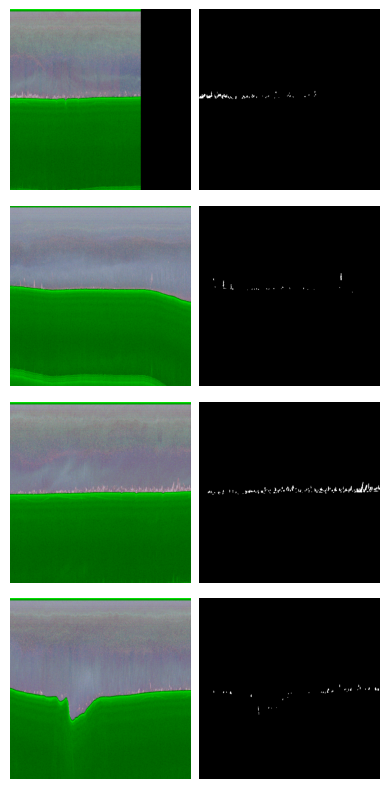

In [263]:
show_img_mask(test_loader, test = True)

# EVALUATION ON TEST DATA

In [269]:
def find_best_checkpoint(checkpoint_dir):
    # List all checkpoint files
    files = os.listdir(checkpoint_dir)
    files = [f for f in files if f.endswith('.ckpt')]

    # Initialize minimum loss to a very high value
    latest_epoch = 0
    best_model_path = None

    # Iterate over files to find the one with the lowest validation loss
    for filename in files:
        parts = filename.split('-')
        # Extract the validation loss part and convert to float
        try:
            epoch = int(parts[0].split('=')[1])
            if epoch >= latest_epoch:
                latest_epoch = epoch
                best_model_path = os.path.join(checkpoint_dir, filename)
        except (IndexError, ValueError):
            continue  # Handle filenames that do not match expected format

    return best_model_path

best_checkpoint_path = find_best_checkpoint(f'./models/checkpoints_{model_name}_{encoder}')
base_model = smp.create_model(model_name,
                         encoder_name = encoder,
                         in_channels = 3,
                         classes = classes).to(device)
trained_model = SegModel.load_from_checkpoint(model = base_model, checkpoint_path = best_checkpoint_path, optimizer=optimizer, criterion=criterion)

In [270]:
tester = pl.Trainer(precision=16, accelerator='gpu')
results = tester.test(trained_model, test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       dice_score           0.9984747767448425
           f1               0.5155467987060547
        iou_score           0.34894275665283203
        precision           0.7706349492073059
         recall             0.3914370536804199
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [266]:
trainer.test(pl_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

ValueError: too many values to unpack (expected 2)

# PREDICTION FOR NEW DATA

In [300]:
prediction_dir_cut = '/home/ubuntu/Sonar_data/Herring_predictions_cut'
prediction_dir = '/home/ubuntu/Sonar_data/Herring_predictions'
trained_model.predict(test_loader, output_dir = prediction_dir_cut)

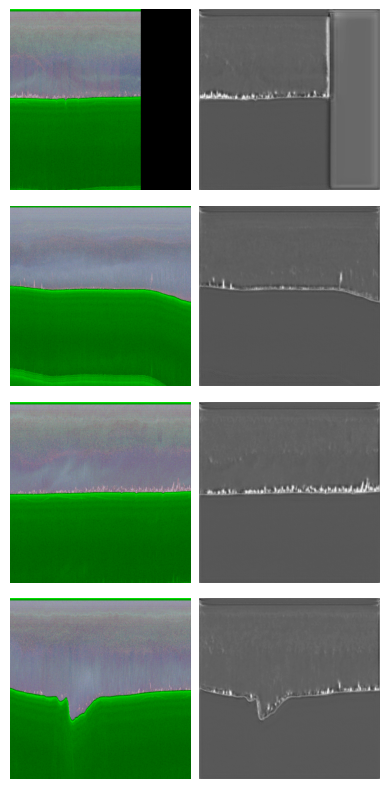

In [309]:
import matplotlib.pyplot as plt

def show_predictions(loader, num_images_to_display = 4, predictions_dir = None):
    images, masks, filenames = next(iter(loader))    

    masks = []
    for f in filenames:
        masks.append(np.load(os.path.join(predictions_dir, f)))
        
    # Convert tensors to numpy arrays for visualization
    images_np = images.numpy()  # In shape (N, C, H, W)
    masks_np = np.concatenate(masks)  
    masks_np = np.expand_dims(masks_np, axis=1) # In shape (N, H, W)
    
    images_np = images_np.transpose((0, 2, 3, 1))
    masks_np = masks_np.transpose((0, 2, 3, 1))
    
    fig, axes = plt.subplots(num_images_to_display, 2, figsize=(4, 2 * num_images_to_display))
    
    for i in range(num_images_to_display):
        # Display the image
        axes[i, 0].imshow(images_np[i])
        axes[i, 0].axis('off')
    
        # Display the mask
        axes[i, 1].imshow(masks_np[i], cmap='gray')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions(test_loader, predictions_dir = prediction_dir_cut)

In [301]:
# Concatenate predictions together

def parse_filename(filename):
    base, _ = os.path.splitext(filename)
    return base.split("_")[:-1]  # Get all parts except extension and last part

def parse_filenames(filenames):
    filenames_dict = {}
    for f in filenames:
        basename = os.path.basename(f)
        f_numb = basename.split("_")[-1][:-4]
        f_name = basename[:-len(f_numb)-5]
        if not f_name in filenames_dict: filenames_dict[f_name] = []
        filenames_dict[f_name].append(int(f_numb))

    ordered_filenames = {}
    for f_name, parts in filenames_dict.items():
        parts = np.sort(parts)
        ordered_list = []
        for part in parts:
            ordered_list.append('%s_%d.npy' % (f_name, part) )
        ordered_filenames[f_name] = ordered_list
    return ordered_filenames

def concat_fragmented_arrays(input_folder, output_folder):
    filenames = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".npy")]
    ordered_filenames = parse_filenames(filenames)

    for f_name, f_list in ordered_filenames.items():
        out_fpath = os.path.join(output_folder, f_name+'.npy')
        data = []
        for f in f_list:
            data.append(np.load(os.path.join(prediction_dir_cut, f)))
        data = np.concatenate(data, axis=1)
        np.save(out_fpath, data)

concat_fragmented_arrays(prediction_dir_cut, prediction_dir)